# CSCG for counterfactual causal reasoning through episodic memories
With two conditions, one that is causally related to coming to late to the airport, and one  that is not.

**Clone the repo from github, Install the necessary libraries**

In [1]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph

***Import the needed python modules***

In [101]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room, forwardE_mp, backtraceE, backtrace, forward_mp, rargmax, forwardE, backtraceE
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import tools

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

np.random.seed(52)

transition_matrix = np.array([   # lines transitions from columns transitions to...
    [0.0, 0.5, 0.0, 0.5, 0.0, 0.0],   # 0, Station to Lunch, Toilet or Train1
    [0.0, 0.0, 0.5, 0.1, 0.0, 0.4],   # 1, Lunch to Train1 or Train2
    [0.0, 0.0, 0.0, 0.1, 0.0, 0.9],   # 2, Toilet to Train1 or Train2
    [0.1, 0.0, 0.0, 0.0, 0.9, 0.0],   # 3, Train1 to Station or Airport
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],   # 4, Aiport to Station
    [0.9, 0.0, 0.0, 0.0, 0.1, 0.0],   # 5, Train2 to Station or Airport
])

seq_length = 10000
seq_state_t0 = 0
pseudocount = 1e-4

n_clones = np.array(
    [1, 1, 1, 2, 1], # define number of clones per state
    dtype = np.int64)

n_iter = 500

#### Generate sequence

In [102]:
seq = tools.generate_markov_seq(transition_matrix, seq_state_t0, seq_length)

# We want the algorithm to figure out the different train contexts by itself, thus we give them the same identity.
seq[seq == 5] = 3

# we create dummy action
a = np.zeros(seq_length, dtype=np.int64)

#### Train CSCG

In [103]:
# Generate data and train a CSCG.
chmm = CHMM(
    n_clones=n_clones,
    pseudocount=pseudocount,
    x=seq, a=a,
    seed=44)

progression = chmm.learn_em_T(seq, a, n_iter=n_iter)



Average number of clones: 1.2


  2%|▏         | 12/500 [00:00<00:03, 133.45it/s, train_bps=0.63]


#### Apply Viterbi pruning

In [104]:
chmm.learn_viterbi_T(seq, a, n_iter=100)

  2%|▏         | 2/100 [00:00<00:04, 22.44it/s, train_bps=0.634]


[np.float32(0.64147085), np.float32(0.6337149), np.float32(0.6337149)]

In [105]:
seq[:20], np.shape(chmm.T[0])

(array([0, 3, 0, 1, 3, 0, 3, 0, 3, 4, 0, 3, 4, 0, 1, 3, 0, 3, 4, 0]), (6, 6))

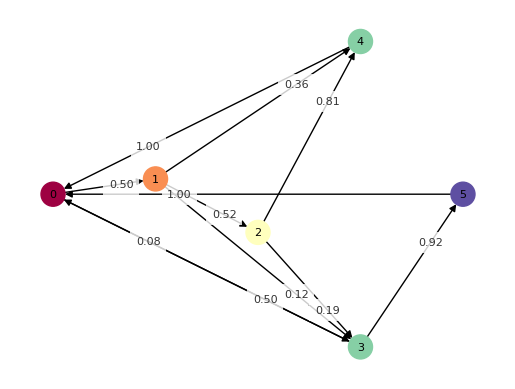

In [106]:
pos = [
    [0, 0.,],
    [1, .01,],
    [2, -.025,],
    [3, -.1],
    [3, .1],
    [4, 0.,],
]


kwargs_nxdraw = {
    'node_size': 300,
    'font_size': 8,
    'arrows': True,
#    'connectionstyle': 'arc,rad=0.4'
}

kwargs_fig = {
    'figsize': [4, 4],
}

kwargs_nxdrawedgelabel = {
    'font_size': 8,
    'label_pos': 0.7,  # Position along edge (0=start, 1=end)
    'bbox': dict(alpha=0.8, facecolor="white", edgecolor="none"),
    'rotate': False,
    'font_color': "#333333",
}

fig, ax = tools.plot_graph(
    chmm, seq, a, output_file="figures/test.pdf",
    pos=pos,
    label_nodes=False,
    kwargs_fig=kwargs_fig,
    kwargs_nxdraw=kwargs_nxdraw,
    kwargs_nxdrawedgelabel=kwargs_nxdrawedgelabel,
)


In [ ]:
#note have another scenario that does not fulfil the criteria

In [108]:
events = {
    "start": 0, 
    "toilet": 1, 
    "lunch": 2, 
    "train_ontime": 3,
    "train_late": 4, 
    "airport": 5
}


# e means miss the plane
# c means going to lunch
# t means going to the toilet

# validate theorem i)
e_given_c_t =  (chmm.T[0, 2, 3] * chmm.T[0, 3, 0] + 
     chmm.T[0, 2, 4] * chmm.T[0, 4, 0])

not_e_given_c_t = (chmm.T[0, 2, 3] * chmm.T[0, 3, 5] + 
     chmm.T[0, 2, 4] * chmm.T[0, 4, 5])

print("P(Missing the plane | Went to lunch | Went to toilet) =", e_given_c_t)
print("P(Catching the plane | Went to lunch | Went to toilet) =", not_e_given_c_t)


# validate theorem ii)
e_given_c_not_t = (chmm.T[0, 1, 3] * chmm.T[0, 3, 0] +
                    chmm.T[0, 1, 4] * chmm.T[0, 4, 0])

not_e_given_c_not_t = (chmm.T[0, 1, 3] * chmm.T[0, 3, 5] +
                    chmm.T[0, 1, 4] * chmm.T[0, 4, 5])

e_given_not_t_not_c = (chmm.T[0, 0, 3] * chmm.T[0, 3, 0] +
                    chmm.T[0, 0, 4] * chmm.T[0, 4, 0])

not_e_given_not_t_not_c = (chmm.T[0, 0, 3] * chmm.T[0, 3, 5] +
                    chmm.T[0, 0, 4] * chmm.T[0, 4, 5])

print("P(Missing the plane | Went to lunch | Did not go to toilet) =", e_given_c_not_t / (e_given_c_not_t + not_e_given_c_not_t))
print("P(Catching the plane | Went to lunch | Did not go to toilet) =", not_e_given_c_not_t / (e_given_c_not_t + not_e_given_c_not_t))
print("P(Missing the plane | Did not go to lunch | Did not go to toilet) =", e_given_not_t_not_c / (e_given_not_t_not_c + not_e_given_not_t_not_c))
print("P(Catching the plane | Did not go to lunch | Did not go to toilet) =", not_e_given_not_t_not_c / (e_given_not_t_not_c + not_e_given_not_t_not_c))


# fulfils inequality
# shows that going to lunch was the cause for missing the plane

P(Missing the plane | Went to lunch | Went to toilet) = 0.82860833
P(Catching the plane | Went to lunch | Went to toilet) = 0.1713907
P(Missing the plane | Went to lunch | Did not go to toilet) = 0.77328396
P(Catching the plane | Went to lunch | Did not go to toilet) = 0.226716
P(Missing the plane | Did not go to lunch | Did not go to toilet) = 0.07520447
P(Catching the plane | Did not go to lunch | Did not go to toilet) = 0.9247955
